<a href="https://colab.research.google.com/github/gkant06/BMS_Capstone/blob/nataliepham6720-patch-1/MNIST_rVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and libraries

In [ ]:
!pip install -qq pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 6.5 MB/s eta 0:00:00


In [ ]:
from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from torch import tensor as tt
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

# Load neural networks for VAE

In [ ]:
def set_deterministic_mode(seed: int) -> None:
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def make_fc_layers(in_dim: int,
                   hidden_dim: int = 128,
                   num_layers: int = 2,
                   activation: str = "tanh"
                   ) -> Type[nn.Module]:
    """
    Generates a module with stacked fully-connected (aka dense) layers
    """
    activations = {"tanh": nn.Tanh, "lrelu": nn.LeakyReLU, "softplus": nn.Softplus}
    fc_layers = []
    for i in range(num_layers):
        hidden_dim_ = in_dim if i == 0 else hidden_dim
        fc_layers.extend(
            [nn.Linear(hidden_dim_, hidden_dim),
            activations[activation]()])
    fc_layers = nn.Sequential(*fc_layers)
    return fc_layers


class fcEncoderNet(nn.Module):
    """
    Simple fully-connected inference (encoder) network
    """
    def __init__(self,
                 in_dim: Tuple[int],
                 latent_dim: int = 2,
                 hidden_dim:int = 128,
                 num_layers: int = 2,
                 activation: str = 'tanh',
                 softplus_out: bool = False
                 ) -> None:
        """
        Initializes module parameters
        """
        super(fcEncoderNet, self).__init__()
        if len(in_dim) not in [1, 2, 3]:
            raise ValueError("in_dim must be (h, w), (h, w, c), or (h*w*c,)")
        self.in_dim = torch.prod(tt(in_dim)).item()

        self.fc_layers = make_fc_layers(
            self.in_dim, hidden_dim, num_layers, activation)
        self.fc11 = nn.Linear(hidden_dim, latent_dim)
        self.fc12 = nn.Linear(hidden_dim, latent_dim)
        self.activation_out = nn.Softplus() if softplus_out else lambda x: x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Forward pass
        """
        x = x.view(-1, self.in_dim)
        x = self.fc_layers(x)
        mu = self.fc11(x)
        log_sigma = self.activation_out(self.fc12(x))
        return mu, log_sigma


class fcDecoderNet(nn.Module):
    """
    Standard decoder for VAE
    """
    def __init__(self,
                 out_dim: Tuple[int],
                 latent_dim: int,
                 hidden_dim:int = 128,
                 num_layers: int = 2,
                 activation: str = 'tanh',
                 sigmoid_out: str = True,
                 ) -> None:
        super(fcDecoderNet, self).__init__()
        if len(out_dim) not in [1, 2, 3]:
            raise ValueError("in_dim must be (h, w), (h, w, c), or (h*w*c,)")
        self.reshape = out_dim
        out_dim = torch.prod(tt(out_dim)).item()

        self.fc_layers = make_fc_layers(
            latent_dim, hidden_dim, num_layers, activation)
        self.out = nn.Linear(hidden_dim, out_dim)
        self.activation_out = nn.Sigmoid() if sigmoid_out else lambda x: x

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        x = self.fc_layers(z)
        x = self.activation_out(self.out(x))
        return x.view(-1, *self.reshape)


class rDecoderNet(nn.Module):
    """
    Spatial generator (decoder) network with fully-connected layers
    """
    def __init__(self,
                 out_dim: Tuple[int],
                 latent_dim: int,
                 hidden_dim:int = 128,
                 num_layers: int = 2,
                 activation: str = 'tanh',
                 sigmoid_out: str = True
                 ) -> None:
        """
        Initializes module parameters
        """
        super(rDecoderNet, self).__init__()
        if len(out_dim) not in [1, 2, 3]:
            raise ValueError("in_dim must be (h, w), (h, w, c), or (h*w*c,)")
        self.reshape = out_dim
        out_dim = torch.prod(tt(out_dim)).item()

        self.coord_latent = coord_latent(latent_dim, hidden_dim)
        self.fc_layers = make_fc_layers(
            hidden_dim, hidden_dim, num_layers, activation)
        self.out = nn.Linear(hidden_dim, 1) # need to generalize to multi-channel (c > 1)
        self.activation_out = nn.Sigmoid() if sigmoid_out else lambda x: x

    def forward(self, x_coord: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        """
        x = self.coord_latent(x_coord, z)
        x = self.fc_layers(x)
        x = self.activation_out(self.out(x))
        return x.view(-1, *self.reshape)


class coord_latent(nn.Module):
    """
    The "spatial" part of the rVAE's decoder that allows for translational
    and rotational invariance (based on https://arxiv.org/abs/1909.11663)
    """
    def __init__(self,
                 latent_dim: int,
                 out_dim: int,
                 activation_out: bool = True) -> None:
        """
        Iniitalizes modules parameters
        """
        super(coord_latent, self).__init__()
        self.fc_coord = nn.Linear(2, out_dim)
        self.fc_latent = nn.Linear(latent_dim, out_dim, bias=False)
        self.activation = nn.Tanh() if activation_out else None

    def forward(self,
                x_coord: torch.Tensor,
                z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        """
        batch_dim, n = x_coord.size()[:2]
        x_coord = x_coord.reshape(batch_dim * n, -1)
        h_x = self.fc_coord(x_coord)
        h_x = h_x.reshape(batch_dim, n, -1)
        h_z = self.fc_latent(z)
        h = h_x.add(h_z.unsqueeze(1))
        h = h.reshape(batch_dim * n, -1)
        if self.activation is not None:
            h = self.activation(h)
        return h

# Load functions for working with image coordinates and labels

In [ ]:
def to_onehot(idx: torch.Tensor, n: int) -> torch.Tensor:
    """
    One-hot encoding of a label
    """
    if torch.max(idx).item() >= n:
        raise AssertionError(
            "Labelling must start from 0 and "
            "maximum label value must be less than total number of classes")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n, device=device)
    return onehot.scatter_(1, idx.to(device), 1)


def grid2xy(X1: torch.Tensor, X2: torch.Tensor) -> torch.Tensor:
    X = torch.cat((X1[None], X2[None]), 0)
    d0, d1 = X.shape[0], X.shape[1] * X.shape[2]
    X = X.reshape(d0, d1).T
    return X


def imcoordgrid(im_dim: Tuple) -> torch.Tensor:
    xx = torch.linspace(-1, 1, im_dim[0])
    yy = torch.linspace(1, -1, im_dim[1])
    x0, x1 = torch.meshgrid(xx, yy)
    return grid2xy(x0, x1)


def transform_coordinates(coord: torch.Tensor,
                          phi: Union[torch.Tensor, float] = 0,
                          coord_dx: Union[torch.Tensor, float] = 0,
                          ) -> torch.Tensor:

    if torch.sum(phi) == 0:
        phi = coord.new_zeros(coord.shape[0])
    rotmat_r1 = torch.stack([torch.cos(phi), torch.sin(phi)], 1)
    rotmat_r2 = torch.stack([-torch.sin(phi), torch.cos(phi)], 1)
    rotmat = torch.stack([rotmat_r1, rotmat_r2], axis=1)
    coord = torch.bmm(coord, rotmat)

    return coord + coord_dx

# Load utility functions for data loading and preprocessing

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor

def get_rotated_mnist(rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
    !tar -zxvf MNIST.tar.gz
    mnist_trainset = datasets.MNIST(
        root='.', train=True, download=False, transform=None)
    imstack_train_r = torch.zeros_like(mnist_trainset.data, dtype=torch.float32)
    labels, angles = [], []
    for i, (im, lbl) in enumerate(mnist_trainset):
        theta = torch.randint(*rotation_range, (1,)).float()
        im = im.rotate(theta.item(), resample=Image.BICUBIC)
        imstack_train_r[i] = ToTensor()(im)
        labels.append(lbl)
        angles.append(torch.deg2rad(theta))
    imstack_train_r /= imstack_train_r.max()
    return imstack_train_r, tt(labels), tt(angles)


def init_dataloader(*args: torch.Tensor, **kwargs: int
                    ) -> Type[torch.utils.data.DataLoader]:

    batch_size = kwargs.get("batch_size", 100)
    tensor_set = torch.utils.data.dataset.TensorDataset(*args)
    data_loader = torch.utils.data.DataLoader(
        dataset=tensor_set, batch_size=batch_size, shuffle=True)
    return data_loader

# Load training data

In [ ]:
train_data, train_labels, angles = get_rotated_mnist(rotation_range=[-60, 61]) # rotation range 60 degree
train_loader = init_dataloader(train_data, batch_size=200)

--2023-02-23 21:15:47--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-02-23 21:15:48--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [             <=>    ]  33.20M  12.5MB/s    in 2.7s    

2023-02-23 21:15:51 (12.5 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

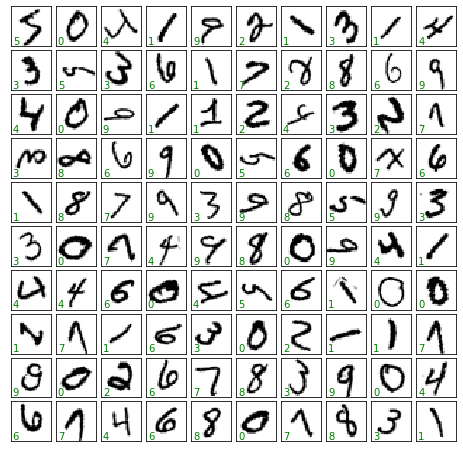

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.item()),
            transform=ax.transAxes, color='green')

# Define model and trainer

In [ ]:
class rVAE(nn.Module):
    """
    Variational autoencoder with rotational and/or transaltional invariance
    """
    def __init__(self,
                 in_dim: Tuple[int],
                 latent_dim: int = 2,
                 coord: int = 3,
                 num_classes: int = 0,
                 hidden_dim_e: int = 128,
                 hidden_dim_d: int = 128,
                 num_layers_e: int = 2,
                 num_layers_d: int = 2,
                 activation: str = "tanh",
                 softplus_sd: bool = True,
                 sigmoid_out: bool = True,
                 seed: int = 1,
                 **kwargs
                 ) -> None:
        """
        Initializes rVAE's modules and parameters
        """
        super(rVAE, self).__init__()
        pyro.clear_param_store()
        set_deterministic_mode(seed)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.encoder_net = fcEncoderNet(
            in_dim, latent_dim+coord, hidden_dim_e,
            num_layers_e, activation, softplus_sd)
        if coord not in [0, 1, 2, 3]:
            raise ValueError("'coord' argument must be 0, 1, 2 or 3")
        dnet = rDecoderNet if coord in [1, 2, 3] else fcDecoderNet
        self.decoder_net = dnet(
            in_dim, latent_dim+num_classes, hidden_dim_d,
            num_layers_d, activation, sigmoid_out)
        self.z_dim = latent_dim + coord
        self.coord = coord
        self.num_classes = num_classes
        self.grid = imcoordgrid(in_dim).to(self.device)
        self.dx_prior = tt(kwargs.get("dx_prior", 0.1)).to(self.device)
        self.to(self.device)

    def model(self,
              x: torch.Tensor,
              y: Optional[torch.Tensor] = None,
              **kwargs: float) -> torch.Tensor:
        """
        Defines the model p(x|z)p(z)
        """
        # register PyTorch module `decoder_net` with Pyro
        pyro.module("decoder_net", self.decoder_net)
        # KLD scale factor (see e.g. https://openreview.net/pdf?id=Sy2fzU9gl)
        beta = kwargs.get("scale_factor", 1.)
        reshape_ = torch.prod(tt(x.shape[1:])).item()
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            with pyro.poutine.scale(scale=beta):
                z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            if self.coord > 0:  # rotationally- and/or translationaly-invariant mode
                # Split latent variable into parts for rotation
                # and/or translation and image content
                phi, dx, z = self.split_latent(z)
                if torch.sum(dx) != 0:
                    dx = (dx * self.dx_prior).unsqueeze(1)
                # transform coordinate grid
                grid = self.grid.expand(x.shape[0], *self.grid.shape)
                x_coord_prime = transform_coordinates(grid, phi, dx)
            # Add class label (if any)
            if y is not None:
                y = to_onehot(y, self.num_classes)
                z = torch.cat([z, y], dim=-1)
            # decode the latent code z together with the transformed coordiantes (if any)
            dec_args = (x_coord_prime, z) if self.coord else (z,)
            loc_img = self.decoder_net(*dec_args)
            # score against actual images ("binary cross-entropy loss")
            pyro.sample(
                "obs", dist.Bernoulli(loc_img.view(-1, reshape_), validate_args=False).to_event(1),
                obs=x.view(-1, reshape_))
            
    def guide(self,
              x: torch.Tensor,
              y: Optional[torch.Tensor] = None,
              **kwargs: float) -> torch.Tensor:
        """
        Defines the guide q(z|x)
        """
        # register PyTorch module `encoder_net` with Pyro
        pyro.module("encoder_net", self.encoder_net)
        # KLD scale factor (see e.g. https://openreview.net/pdf?id=Sy2fzU9gl)
        beta = kwargs.get("scale_factor", 1.)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder_net(x)
            # sample the latent code z
            with pyro.poutine.scale(scale=beta):
                pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def split_latent(self, z: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Split latent variable into parts for rotation
        and/or translation and image content
        """
        phi, dx = tt(0), tt(0)
        # rotation + translation
        if self.coord == 3: 
            phi = z[:, 0]  # encoded angle
            dx = z[:, 1:3]  # translation
            z = z[:, 3:]  # image content
        # translation only
        elif self.coord == 2:
            dx = z[:, :2]
            z = z[:, 2:]
        # rotation only
        elif self.coord == 1: 
            phi = z[:, 0]
            z = z[:, 1:]
        return phi, dx, z
    
    def _encode(self, x_new: torch.Tensor, **kwargs: int) -> torch.Tensor:
        """
        Encodes data using a trained inference (encoder) network
        in a batch-by-batch fashion
        """
        def inference() -> np.ndarray:
            with torch.no_grad():
                encoded = self.encoder_net(x_i)
            encoded = torch.cat(encoded, -1).cpu()
            return encoded

        x_new = x_new.to(self.device)
        num_batches = kwargs.get("num_batches", 10)
        batch_size = len(x_new) // num_batches
        z_encoded = []
        for i in range(num_batches):
            x_i = x_new[i*batch_size:(i+1)*batch_size]
            z_encoded_i = inference()
            z_encoded.append(z_encoded_i)
        x_i = x_new[(i+1)*batch_size:]
        if len(x_i) > 0:
            z_encoded_i = inference()
            z_encoded.append(z_encoded_i)
        return torch.cat(z_encoded)

    def encode(self, x_new: torch.Tensor, **kwargs: int) -> torch.Tensor:
        """
        Encodes data using a trained inference (encoder) network
        (this is baiscally a wrapper for self._encode)
        """
        if isinstance(x_new, torch.utils.data.DataLoader):
            x_new = train_loader.dataset.tensors[0]
        z = self._encode(x_new)
        z_loc = z[:, :self.z_dim]  # z_mean
        z_scale = z[:, self.z_dim:] # z_std
        return z_loc, z_scale, z

    def manifold2d(self, d: int, **kwargs: Union[str, int]) -> torch.Tensor:
        """
        Plots a learned latent manifold in the image space
        """
        if self.num_classes > 0:
            cls = tt(kwargs.get("label", 0))
            cls = to_onehot(cls.unsqueeze(0), self.num_classes)
        grid_x = norm.ppf(torch.linspace(0.95, 0.05, d))
        grid_y = norm.ppf(torch.linspace(0.05, 0.95, d))
        loc_img_all = []
        for i, xi in enumerate(grid_x):
            for j, yi in enumerate(grid_y):
                z_sample = tt([xi, yi]).float().to(self.device).unsqueeze(0)
                if self.num_classes > 0:
                    z_sample = torch.cat([z_sample, cls], dim=-1)
                d_args = (self.grid.unsqueeze(0), z_sample) if self.coord > 0 else (z_sample,)
                loc_img = self.decoder_net(*d_args)
                loc_img_all.append(loc_img.detach().cpu())
        loc_img_all = torch.cat(loc_img_all)

        grid = make_grid(loc_img_all[:, None], nrow=d,
                         padding=kwargs.get("padding", 2),
                         pad_value=kwargs.get("pad_value", 0))
        plt.figure(figsize=(8, 8))
        plt.imshow(grid[0], cmap=kwargs.get("cmap", "gnuplot"),
                   origin=kwargs.get("origin", "upper"),
                   extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("$z_1$", fontsize=18)
        plt.ylabel("$z_2$", fontsize=18)
        plt.show()

In [ ]:
class SVItrainer:
    """
    Stochastic variational inference (SVI) trainer for 
    unsupervised and class-conditioned variational models
    """
    def __init__(self,
                 model: Type[nn.Module],
                 optimizer: Type[optim.PyroOptim] = None,
                 loss: Type[infer.ELBO] = None,
                 seed: int = 1
                 ) -> None:
        """
        Initializes the trainer's parameters
        """
        pyro.clear_param_store()
        set_deterministic_mode(seed)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if optimizer is None:
            optimizer = optim.Adam({"lr": 1.0e-3})
        if loss is None:
            loss = infer.Trace_ELBO()
        self.svi = infer.SVI(model.model, model.guide, optimizer, loss=loss)
        self.loss_history = {"training_loss": [], "test_loss": []}
        self.current_epoch = 0

    def train(self,
              train_loader: Type[torch.utils.data.DataLoader],
              **kwargs: float) -> float:
        """
        Trains a single epoch
        """
        # initialize loss accumulator
        epoch_loss = 0.
        # do a training epoch over each mini-batch returned by the data loader
        for data in train_loader:
            if len(data) == 1:  # VAE mode
                x = data[0]
                loss = self.svi.step(x.to(self.device), **kwargs)
            else:  # VED or cVAE mode
                x, y = data
                loss = self.svi.step(
                    x.to(self.device), y.to(self.device), **kwargs)
            # do ELBO gradient and accumulate loss
            epoch_loss += loss

        return epoch_loss / len(train_loader.dataset)

    def evaluate(self,
                 test_loader: Type[torch.utils.data.DataLoader],
                 **kwargs: float) -> float:
        """
        Evaluates current models state on a single epoch
        """
        # initialize loss accumulator
        test_loss = 0.
        # compute the loss over the entire test set
        with torch.no_grad():
            for data in test_loader:
                if len(data) == 1:  # VAE mode
                    x = data[0]
                    loss = self.svi.step(x.to(self.device), **kwargs)
                else:  # VED or cVAE mode
                    x, y = data
                    loss = self.svi.step(
                        x.to(self.device), y.to(self.device), **kwargs)
                test_loss += loss

        return test_loss / len(test_loader.dataset)

    def step(self,
             train_loader: Type[torch.utils.data.DataLoader],
             test_loader: Optional[Type[torch.utils.data.DataLoader]] = None,
             **kwargs: float) -> None:
        """
        Single training and (optionally) evaluation step 
        """
        self.loss_history["training_loss"].append(self.train(train_loader,**kwargs))
        if test_loader is not None:
            self.loss_history["test_loss"].append(self.evaluate(test_loader,**kwargs))
        self.current_epoch += 1

    def print_statistics(self) -> None:
        """
        Prints training and test (if any) losses for current epoch
        """
        e = self.current_epoch
        if len(self.loss_history["test_loss"]) > 0:
            template = 'Epoch: {} Training loss: {:.4f}, Test loss: {:.4f}'
            print(template.format(e, self.loss_history["training_loss"][-1],
                                  self.loss_history["test_loss"][-1]))
        else:
            template = 'Epoch: {} Training loss: {:.4f}'
            print(template.format(e, self.loss_history["training_loss"][-1]))

# Train different VAE models

### Vanilla VAE

In [ ]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
vae = rVAE(in_dim, latent_dim=2, coord=0, seed=0)

# Initialize SVI trainer
trainer = SVItrainer(vae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader)
    trainer.print_statistics()

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1 Training loss: 226.3769
Epoch: 2 Training loss: 192.3910
Epoch: 3 Training loss: 186.0978
Epoch: 4 Training loss: 182.1554
Epoch: 5 Training loss: 179.5576
Epoch: 6 Training loss: 177.5475
Epoch: 7 Training loss: 175.8627
Epoch: 8 Training loss: 174.2992
Epoch: 9 Training loss: 173.0215
Epoch: 10 Training loss: 171.8614
Epoch: 11 Training loss: 170.9964
Epoch: 12 Training loss: 170.1615
Epoch: 13 Training loss: 169.4049
Epoch: 14 Training loss: 168.8291
Epoch: 15 Training loss: 168.2751
Epoch: 16 Training loss: 167.7995
Epoch: 17 Training loss: 167.3337
Epoch: 18 Training loss: 166.9394
Epoch: 19 Training loss: 166.5415
Epoch: 20 Training loss: 166.1454
Epoch: 21 Training loss: 165.9246
Epoch: 22 Training loss: 165.5953
Epoch: 23 Training loss: 165.2416
Epoch: 24 Training loss: 164.9785
Epoch: 25 Training loss: 164.7263
Epoch: 26 Training loss: 164.4742
Epoch: 27 Training loss: 164.2308
Epoch: 28 Training loss: 164.0417
Epoch: 29 Training loss: 163.8064
Epoch: 30 Training loss

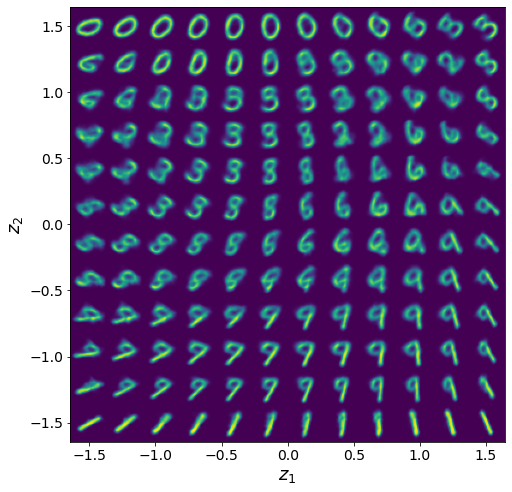

In [ ]:
vae.manifold2d(d=12, cmap='viridis')

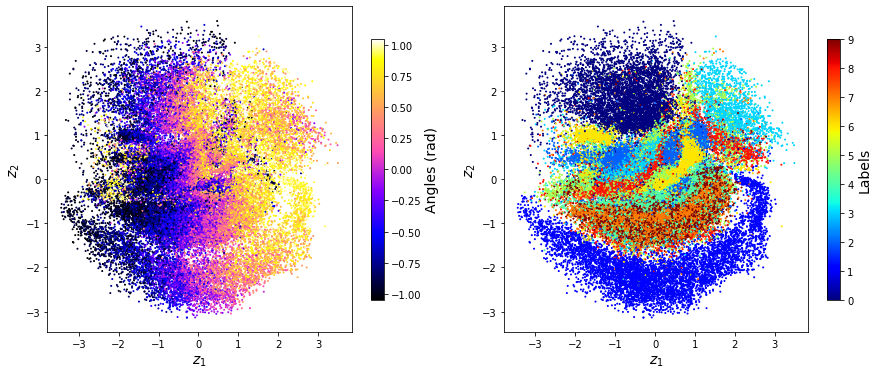

In [ ]:
z_mean, z_sd, z = vae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

(60000,)
# digits: 10; # samples: 60000; # features 4
[5.10548127e-01 4.89106834e-01 2.67168090e-04 7.78712746e-05]
[0.49652378 0.48598579 0.01135832 0.00613212]


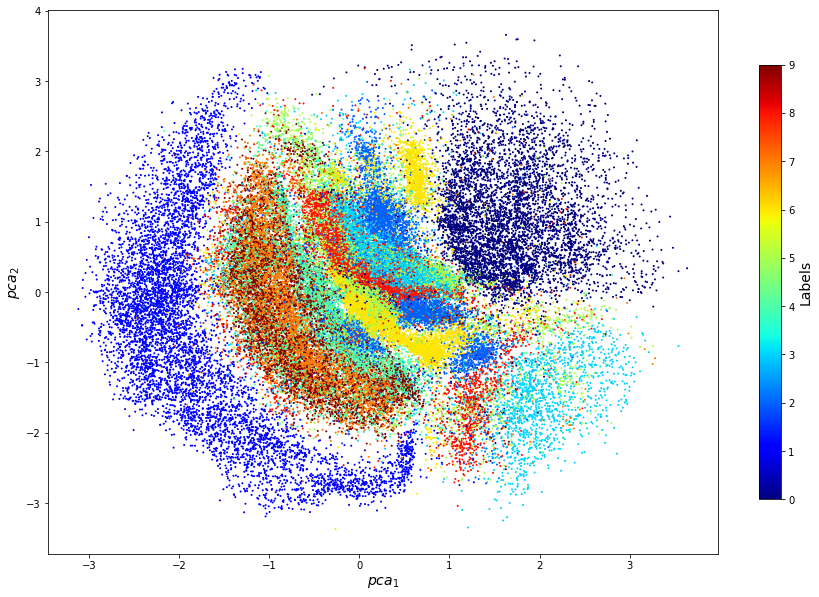

In [ ]:
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

t = np.array(train_labels) # tensor to array
print(t.shape)

# load input
z_mean, z_sd, z = vae.encode(train_data)
# X input for encoder: 60000 x 28 x 28 -->  flatten in to 60000 x 784
# Fully connected NN 

# dimension of z matrix for input of PCA: 60000 x 6

(n_samples, n_features), n_digits = z.shape, np.unique(t).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

pca = PCA()
pca.fit(z)

print(pca.explained_variance_ratio_)
print(pca.singular_values_/sum(pca.singular_values_))

import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(z)


fig, ax = plt.subplots(1, figsize =(15, 10))
im = ax.scatter(reduced_data[:,0], reduced_data[:,1], c=train_labels, s=1, cmap='jet')
ax.set_xlabel("$pca_1$", fontsize=14)
ax.set_ylabel("$pca_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

In [ ]:
# Load data
images = np.array(train_data) #data['images']
labels = np.array(train_labels) #data['labels']

z_sample = np.array(reduced_data) # pca of latent features

In [ ]:
!pip install --q dash==2.0.0 jupyter-dash==0.4.0;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.4 MB/s eta 0:00:00


In [ ]:
import io
import base64
import pickle

from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, no_update
import plotly.graph_objects as go

from PIL import Image
import numpy as np

# np_array to images functions
def np_image_to_base64(im_matrix):
    im_matrix_uint8 = im_matrix.astype(np.uint8)
    im = Image.fromarray(im_matrix_uint8)
    buffer = io.BytesIO()
    im.save(buffer, format="jpeg")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/jpeg;base64, " + encoded_image
    return im_url

In [ ]:
fig = go.Figure(data=[go.Scatter(
    x= z_sample[:, 0],
    y= z_sample[:, 1],
    mode='markers',
    marker=dict(color= labels, 
                colorscale='magma', 
                size=2, 
                colorbar=dict(thickness=20)),
)])

fig.update_traces(
    hoverinfo="none",
    hovertemplate=None,
)

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-10,10]),
        yaxis=dict(range=[-10,10]),  
    ),
    autosize=False,
    width=800,
    height=800,
)

app = JupyterDash(__name__)

app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
    ],
)

@app.callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]

    im_matrix = images[num]
    im_url = np_image_to_base64(im_matrix*255)
    children = [
        html.Div([
            html.Img(
                src=im_url,
                style={"width": "50px", 'display': 'block', 'margin': '0 auto'},
            ),
            # html.P("MNIST Digit " + str(labels[num]), style={'font-weight': 'bold'})
        ])
    ]

    return True, bbox, children

if __name__ == "__main__":
    app.run_server(mode='inline', debug=True)

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.cluster import KMeans
# K-means clustering
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
model = kmeans.fit(z)
labels = model.predict(z)

from sklearn import metrics
metrics.homogeneity_score(t,labels)

0.3444925257490998

### Rotationally-invariant VAE (rVAE)

In [ ]:
# Re-initialize dataloader
train_loader = init_dataloader(train_data, batch_size=200)

In [ ]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
rvae = rVAE(in_dim, latent_dim=2, coord=1, seed=0)

# Initialize SVI trainer
trainer = SVItrainer(rvae)
# Train for n epochs:
for e in range(100):
    # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
    # It is optional, and the rvae will also work without it
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 252.9296
Epoch: 2 Training loss: 206.6064
Epoch: 3 Training loss: 197.1542
Epoch: 4 Training loss: 189.3891
Epoch: 5 Training loss: 183.8661
Epoch: 6 Training loss: 180.5978
Epoch: 7 Training loss: 178.6414
Epoch: 8 Training loss: 177.1125
Epoch: 9 Training loss: 176.0373


In [ ]:
rvae.manifold2d(d=12, cmap="viridis")

In [ ]:
z_mean, z_sd, z = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

In [ ]:
print(z.shape) # rotated angle [0], translation [1,2], image latent features [3,4,5]

In [ ]:
# PCA for visualize latent features
# Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

import numpy as np
from sklearn.decomposition import PCA

# load input
(n_samples, n_features), n_digits = z.shape, np.unique(t).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

pca = PCA()
pca.fit(z)

print(pca.explained_variance_ratio_)
print(pca.singular_values_/sum(pca.singular_values_))

import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(z)


fig, ax = plt.subplots(1, figsize =(15, 10))
im = ax.scatter(reduced_data[:,0], reduced_data[:,1], c=train_labels, s=1, cmap='jet')
ax.set_xlabel("$pca_1$", fontsize=14)
ax.set_ylabel("$pca_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

In [ ]:
# Plotly hovering plot
# Reference: https://dash.plotly.com/dash-core-components/

# Load data
images = np.array(train_data) #data['images']
labels = np.array(train_labels) #data['labels']

z_sample = np.array(reduced_data) # pca of latent features

fig = go.Figure(data=[go.Scatter(
    x= z_sample[:, 0],
    y= z_sample[:, 1],
    mode='markers',
    marker=dict(color= labels, 
                colorscale='magma', 
                size=2, 
                colorbar=dict(thickness=20)),
)])

fig.update_traces(
    hoverinfo="none",
    hovertemplate=None,
)

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-10,10]),
        yaxis=dict(range=[-10,10]),  
    ),
    autosize=False,
    width=800,
    height=800,
)

app = JupyterDash(__name__)

app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip-5", direction='bottom'),
    ],
)

@app.callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]

    im_matrix = images[num]
    im_url = np_image_to_base64(im_matrix*255)
    children = [
        html.Div([
            html.Img(
                src=im_url,
                style={"width": "50px", 'display': 'block', 'margin': '0 auto'},
            ),
            html.P("MNIST Digit " + str(labels[num]), style={'font-weight': 'bold'})
        ])
    ]

    return True, bbox, children

if __name__ == "__main__":
    app.run_server(mode='inline', debug=True)

In [ ]:
# K-means clustering
kmeans = KMeans(init="k-means++", n_clusters=n_digits)
model = kmeans.fit(z)
labels = model.predict(z)

from sklearn import metrics
#metrics.homogeneity_score(t,labels)
metrics.classification_report(t,labels)

In [ ]:
# K-means clustering - baseline result
#X = train_data
data = np.array(train_data)
X = np.array([data[i,:,:].flatten() for i in range(data.shape[0])])
print(X.shape)

kmeans = KMeans(init="k-means++", n_clusters=n_digits)
model = kmeans.fit(X)
labels = model.predict(X)

from sklearn import metrics
#metrics.homogeneity_score(t,labels)
metrics.classification_report(t,labels)